### Basic SIR Model Demonstration

In this file, we will go over the basics of the Susceptible-Infected-Recovered (SIR) model, without demographics.
As a reminder, the SIR model is defined as

$$
\begin{align*}
\dot{S} &= -\beta SI\\
\dot{I} &= \beta SI - \gamma I\\
\dot{R} &= \gamma I
\end{align*}
$$

Where $S$ is the number of susceptible individuals, $I$ is the number of infected indivduals and $R$ is the number of recovered indivuals.
The model also has two parameters, $\beta$ for the transmission rate and $\gamma$ for the recovery rate.

This code below implements a numerical solution to a simple SIR model without demographics.
To run this code, we will use the numpy package for handeling arrays, the solve_ivp function from scipy to handle the numerical solving, and matplotlib for plotting.

In [113]:
import numpy as np
import math

from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [114]:
def birth(t, peaks):
    time = t%3650
    if(peaks==2):
        #bimodal normal distribution according to https://www.unl.edu/cbrassil/ELME/distributions.pdf
        #Amplification
        z=2
        #Stdev1
        a=30
        #Mean1
        b=100
        #Stdev2
        c=16
        #Mean2
        d=300
        #Y intercept
        e=.35
        x=(z/(math.sqrt(2*math.pi*a**2)))*math.e**(-.5*((time-b)/a)**2)+(z/(math.sqrt(2*math.pi*c**2)))*math.e**(-.5*((time-d)/c)**2)+e
    elif(peaks==1):
        #Amplification
        a=2
        #Stdev
        b=50
        #Mean
        c=182.5
        #Y intercept
        d=.4
        x=(a/(b*math.sqrt(2*math.pi)))*math.e**(-.5*((time-c)/b)**2)+d
    return x

def betaPoint(t, start, end, mid):
    time=t%3650
    tmid=(start+end)/2
    if(time<tmid):
        x=float((2*mid)/(1+math.e**(-(time-start))))
    else:
        x=float((2*mid)/(1+math.e**((time-end))))
    print(x)
    return x

def betaVector(t, start, end, mid):
    betas=t.copy()
    for beta in betas:
        beta=betaPoint(beta,start,end, mid)
    return betas


First, we can create a function which takes in the state of the system (number of susceptible, infected and recovered indivudals) and returns the rate of change for each compartment.

In [115]:
def SI(t, X, Bj, Ba, theta, death, maturity, peaks, startJ, endJ, startA, endA):
    '''
    Define the dynamics of the system for the basic SIR model

    Inputs:
        t: The time state variable for non-autonomous systems, not used here but required by solve_ivp
        X: Vectorized state variables where X = (S, I, R)
        beta: Transmission rate parameter
        gamma: Recovery rate parameter
        theta: Population density negation parameter
        birth: Birth rate paremeter
        death: Death rate parameter
        K: Carrying Capacity parameter

    Returns:
        (dS, dI, dR): Tuple of the rates of change for each state variable
    '''

 
    #Unpack the tuple containing the values for S, I, and R
    Sj, Sa, Ij, Ia = X

    dSj=birth(t,peaks)*Sa-betaPoint(t,startJ,endJ, Bj)*Sj*Ia-theta*Sj*(Sa+Ia)-maturity*Sj-death*Sj
    dSa=maturity*Sj-Ba*Sa*Ia-death*Sa
    dIj=betaPoint(t,startJ,endJ, Bj)*Sj*Ia-maturity*Ij-death*Ij
    dIa=maturity*Ij+Ba*Sa*Ia-death*Ia


    #Calculate the differentials
    #dS = birth(t,peaks)*S-theta*S*(S+I)-beta*S*I - death*S
    #dI = beta*S*I - death*I

    return (dSj, dSa, dIj, dIa)

Next, we define a few values needed to run the simulation.
First we define the initial conditions with `X_0`.
This describes the starting number for each of our three compartments (susceptible, infected and recovered).
For systems with a global attractor (a single globally stable equilibrium), the initials conditions do not matter for the final equilibirum, but this is not the case for our SIR model.

Next, we define a variable `t`, which is a tuple with two values.
The first value is the initial time point and the second is the final time point.
This tells the numerical solver the time range over which to produce a solution.

Finally, we set values for our two simulation parameters, beta and gamma for the transmission rate and recovery rate.

In [116]:
#Set the initial conditions for the number of susceptible, infected and recovered individuals
X_0 = (50, 0, 5, 0)

#Set the time range over which to solve the system
t = (0, 3650)

#Set the transmission and recovery parameters
Bj = 0.008
Ba=.006
theta = 0.0005
death = .2
maturity=.3
peaks = 1
startJ=1000
endJ=2000
startA=1000
endA=2000


Now we are ready to compute our solution. To do this, we use the `solve_ivp` function from scipy.
This takes in several paramters:
1. The function that returns the differentials (SIR)
2. The time range to compute the solution
3. The initial conditions
4. A tuple of parameters

We have also defined an addition keyword argument, `max_step`, which is not strictly necesary, but can be used to produce smoother results.
The `solve_ivp` function returns a class structure which has several important attributes:
- solution.y: a matrix of results where the rows are the compartments and the columns are the time points
- solution.t: the time points at which the solution is calcuated (depending on the algorithm, they may not be evenly spaced)

In [117]:
#Run the solve_ivp function to get a numerical solution
solution = solve_ivp(SI, t, X_0, args=(Bj, Ba, theta, death, maturity, peaks, startJ, endJ, startA, endA), max_step=0.1)

Sj = solution.y[0, :]
Sa = solution.y[1, :]
Ij = solution.y[2, :]
Ia = solution.y[3, :]



time_points = solution.t
births = birth(time_points, peaks)
#betas = betaVector(time_points, 1000, 2000)

OverflowError: (34, 'Result too large')

Finally, we can graph the solution using the matplotlib package

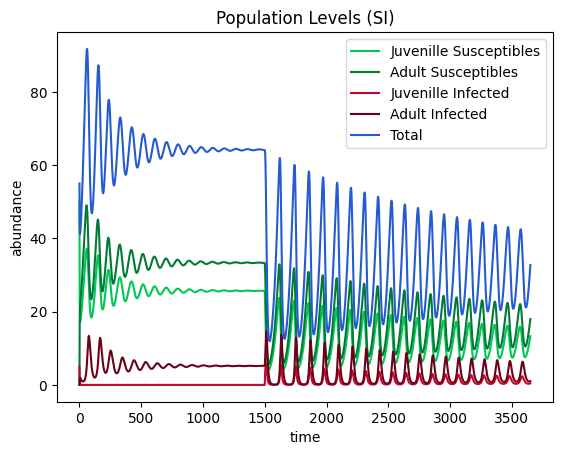

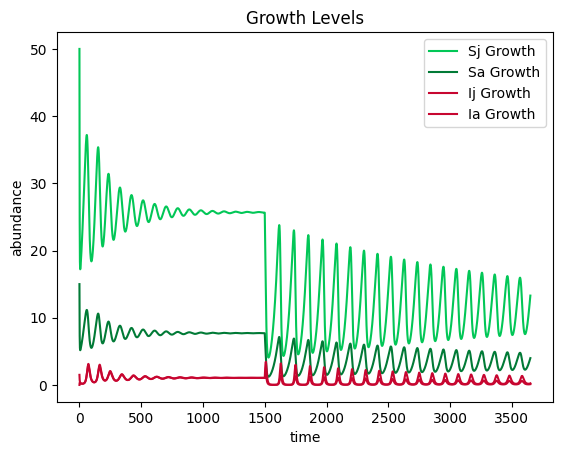

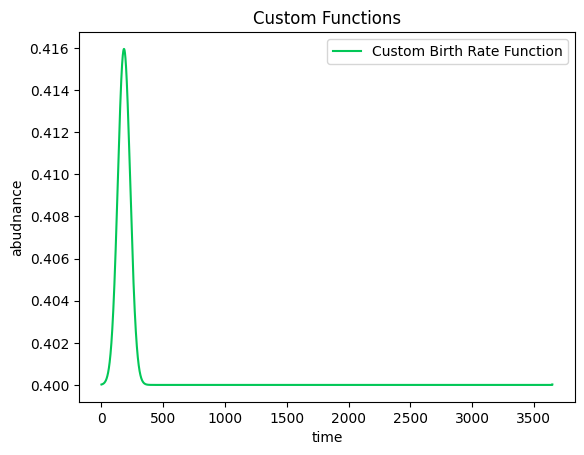

In [ ]:
colSj='#02c757'
colSa='#017a36'
colIj='#c70630'
colIa='#6b0219'
colTot='#245bd1'

fig, populationGraph = plt.subplots()
populationGraph.set_title('Population Levels (SI)')
populationGraph.plot(time_points, Sj, label='Juvenille Susceptibles', color=colSj)
populationGraph.plot(time_points, Sa, label='Adult Susceptibles', color=colSa)
populationGraph.plot(time_points, Ij, label='Juvenille Infected', color=colIj)
populationGraph.plot(time_points, Ia, label='Adult Infected', color=colIa)
populationGraph.plot(time_points, Sj+Sa+Ij+Ia, label='Total', color=colTot)
populationGraph.set_xlabel('time')
populationGraph.set_ylabel('abundance')
populationGraph.legend()

fig, birthGraph = plt.subplots()
birthGraph.set_title('Growth Levels')
birthGraph.plot(time_points, (1*Sj), label='Sj Growth', color=colSj)
birthGraph.plot(time_points, maturity*Sj, label='Sa Growth', color=colSa)
birthGraph.plot(time_points, Bj*Sj*Ia, label='Ij Growth', color=colIj)
birthGraph.plot(time_points, maturity*Ij+Ba*Sa*Ia, label='Ia Growth', color=colIj)
birthGraph.set_xlabel('time')
birthGraph.set_ylabel('abundance')
birthGraph.legend()

# fig, deathGraph = plt.subplots()
# deathGraph.set_title('Death Levels')
# deathGraph.plot(time_points, theta*S*(S+I)+death*S, label='Susceptible Deaths Per Day', color='#23a81e')
# deathGraph.plot(time_points, death*I, label='Infected Deaths Per Day', color='#c70630')
# deathGraph.set_xlabel('time')
# deathGraph.set_ylabel('abundance')
# deathGraph.legend()

fig, custom = plt.subplots()
custom.set_title('Custom Functions')
custom.plot(time_points, births, label='Custom Birth Rate Function', color=colSj)
custom.plot()
custom.set_xlabel('time')
custom.set_ylabel('abudnance')
custom.legend()

# fig, custom2 = plt.subplots()
# custom2.set_title('Custom Juvenille Transmission Function')
# custom2.plot(time_points, betaVector(time_points, 1000, 2000), label='Infection Rate', color=colIj)
# custom2.plot()
# custom2.set_xlabel('time')
# custom2.set_ylabel('abundance')
# custom2.legend()
